In [ ]:
!pip install zarr
!pip install netCDF4
# TODO: convert to zarr for faster reads

In [ ]:
from dask.distributed import LocalCluster
import numpy as np
import xarray as xr
import gc
from tqdm import tqdm

# We want to test on 1000 uncompressed entries each.
# This would take up about 25GB of RAM => Does not fit into memory on my system.
def write_noise(nfiles=10):
    for i in tqdm(range(nfiles)):
        da = xr.DataArray(
            np.random.default_rng().standard_normal(size=(100, 1801, 3600), dtype="float32"),
            coords={"time": np.arange(100), "x": np.arange(1801), "y": np.arange(3600)},
        )
        da.to_netcdf(f"array{i}.nc", engine="h5netcdf", encoding={"time": {"zlib": True, "complevel": 9}})
        gc.collect()

if __name__ == "__main__":
    cluster=LocalCluster(n_workers=4, memory_limit="2.5GiB")
    client = cluster.get_client()
    write_noise()
    print("25GB Worth of noise written to disk.")


In [1]:
import os
from pathlib import Path
os.makedirs("/content/bigfile/", exist_ok=True)

SOURCEDIR = "/content/"
TARGETDIR = "/content/bigfile/"

netcdf_files = [x for x in os.listdir(SOURCEDIR) if "array" in x]
filepaths_full = [SOURCEDIR + file for file in netcdf_files]
test = [Path(f).exists() for f in filepaths_full]

In [2]:
os.getcwd()
filepaths_full
TARGETDIR
test

[True, True, True, True, True, True, True, True, True, True]

In [ ]:
import netCDF4
import xarray as xr
from tqdm import tqdm
from dask.distributed import LocalCluster
cluster=LocalCluster(n_workers=1, memory_limit="4GiB")
client = cluster.get_client()
client.amm.start()

# Lazy dataset
ds = xr.open_mfdataset(
    filepaths_full,
    combine='nested',
    concat_dim='time',
    # TODO: benchmark with chunked times, should write faster
    chunks={"x": 60, "y": 60},
    data_vars="minimal"
)

outfile = TARGETDIR + "combined.zarr"

ds.to_zarr(outfile, mode="w")  # Faster reads than netcdf

In [1]:
import xarray as xr

# Use Dask for lazy loading
ds = xr.open_zarr("./bigfile/combined.zarr", chunks={"x": 60, "y": 60})
ds

<xarray.Dataset> Size: 26GB
Dimensions:                        (time: 1000, x: 1801, y: 3600)
Coordinates:
  * y                              (y) int64 29kB 0 1 2 3 ... 3597 3598 3599
  * time                           (time) int64 8kB 0 1 2 3 4 ... 95 96 97 98 99
  * x                              (x) int64 14kB 0 1 2 3 ... 1798 1799 1800
Data variables:
    __xarray_dataarray_variable__  (time, x, y) float32 26GB dask.array<chunksize=(100, 60, 60), meta=np.ndarray>

In [33]:
import xarray as xr
import math
import numpy as np

def pad_xarray_to_multiple(ds: xr.Dataset, var_name: str, multiple_y=60, multiple_x=60):
    da = ds[var_name]
    T, Y, X = da.sizes['time'], da.sizes['y'], da.sizes['x']

    # Calculate padding sizes
    new_Y = math.ceil(Y / multiple_y) * multiple_y
    new_X = math.ceil(X / multiple_x) * multiple_x
    pad_Y = new_Y - Y
    pad_X = new_X - X

    # Apply lazy padding (right side only, to keep alignment)
    da_padded = da.pad(
        y=(0, pad_Y),
        x=(0, pad_X),
        constant_values=-1000.0
    )

    return da_padded


In [34]:
padded_da = pad_xarray_to_multiple(ds, '__xarray_dataarray_variable__')

print(padded_da)  # still a lazy Dask-backed array

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1000, x: 1860, y: 3600)> Size: 27GB
dask.array<concatenate, shape=(1000, 1860, 3600), dtype=float32, chunksize=(100, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 29kB 0.0 1.0 2.0 3.0 ... 3.597e+03 3.598e+03 3.599e+03
  * time     (time) int64 8kB 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * x        (x) float64 15kB 0.0 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan


In [35]:
time_len = 1000
x_len = 1860
y_len = 3600

In [ ]:
from dask.distributed import Client

# For Colab: use a local client
client = Client(processes=False)  # or Client() if you want multiprocessing


temp = padded_da
CHUNK=60
y_size = min(CHUNK, y_len - 0)
x_size = min(CHUNK, x_len - 0)
# Lazy-loaded Dask chunk
chunk = temp.isel(y=slice(0, 0 + y_size), x=slice(0, 0 + x_size))
# resolve lazy loaded chunk
# chunk_var = chunk['__xarray_dataarray_variable__']
chunk_np = chunk.values

#queue.put((y, x, chunk_np))
chunk_np

In [37]:
print(padded_da)

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1000, x: 1860, y: 3600)> Size: 27GB
dask.array<concatenate, shape=(1000, 1860, 3600), dtype=float32, chunksize=(100, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 29kB 0.0 1.0 2.0 3.0 ... 3.597e+03 3.598e+03 3.599e+03
  * time     (time) int64 8kB 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * x        (x) float64 15kB 0.0 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan


In [38]:
slice_2d = padded_da.isel(time=0)
# slice_2d.shape
slice_np = slice_2d.values

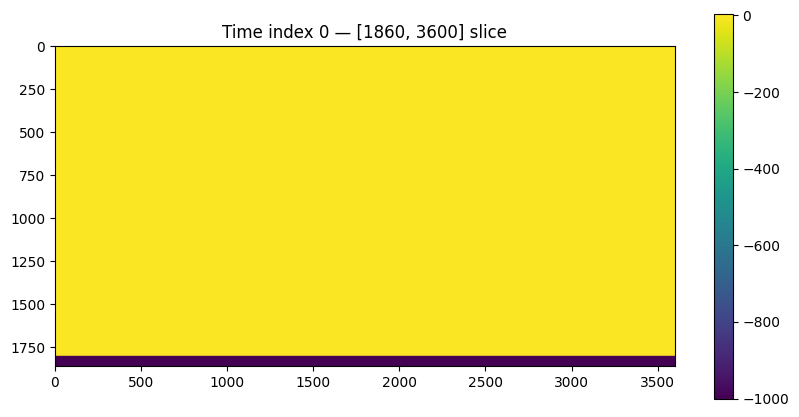

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(slice_np)
plt.colorbar()
plt.title("Time index 0 — [1860, 3600] slice")
plt.show()


In [150]:
import numpy as np
import cupy as cp
import xarray as xr
import threading
from queue import Queue
from tqdm.notebook import tqdm


# Simulate a big dataset: [1801, 3600, 48000]
H, W, T = 3600, 1860, 1000
CHUNK = 60
queue = Queue(maxsize=40)

# Simulate compressed dataset using xarray
def create_fake_data():
    temp_data = np.random.uniform(270, 310, size=(H, W, T)).astype(np.float32)
    ds = xr.Dataset({"temp": (("lat", "lon", "time"), temp_data)},
                    coords={"lat": np.arange(H), "lon": np.arange(W), "time": np.arange(T)})
    return ds

# I/O thread reads and pushes to queue
def io_worker(ds):
    for y in range(0, H, CHUNK):
        for x in range(0, W, CHUNK):
            y_size = min(CHUNK, H - y)
            x_size = min(CHUNK, W - x)
            chunk = ds["temp"].isel(lat=slice(y, y + y_size), lon=slice(x, x + x_size)).values
            queue.put((y, x, chunk))  # shape [y_size, x_size, T]

def io_worker_lazy(temp):
    total_chunks = ((H + CHUNK - 1) // CHUNK) * ((W + CHUNK - 1) // CHUNK)
    pbar = tqdm(total=total_chunks, desc="Reading chunks")

    for y in range(0, H, CHUNK):
        for x in range(0, W, CHUNK):
            y_size = min(CHUNK, H - y)
            x_size = min(CHUNK, W - x)

            # Load the real data
            chunk = temp.isel(y=slice(y, y + y_size), x=slice(x, x + x_size))
            chunk_var = chunk['__xarray_dataarray_variable__']
            chunk_np = chunk_var.values  # shape (T, y_size, x_size)

            # Pad if needed
            if y_size < CHUNK or x_size < CHUNK:
                padded_chunk = np.zeros((chunk_np.shape[0], CHUNK, CHUNK), dtype=chunk_np.dtype)
                padded_chunk[:, :y_size, :x_size] = chunk_np
                chunk_np = padded_chunk

            queue.put((y, x, chunk_np))  # shape [T, CHUNK, CHUNK]
            pbar.update(1)

    pbar.close()
    queue.put(None)

# GPU worker processes chunks
def gpu_worker_kernel(results_array):
    while True:
        # item = queue.get()
        item = data_queue.get()
        if item is None:
            break  # Exit cleanly
        y, x, chunk_np = item
        # print(chunk_np.shape) # (1000, 60, 60)
        if chunk_np.shape[1] == 0:
          print("here") # for some reason chunk_np has shape (1000, 0, 60)
          continue
        chunk_gpu = cp.asarray(chunk_np)  # shape (y_chunk, x_chunk, T)
        y_size, x_size = chunk_gpu.shape[1:]

        # Threshold per pixel (0th percentile to debug => should return T for every pixel)
        # threshold = cp.percentile(chunk_gpu, 90, axis=2, keepdims=True)
        threshold = cp.percentile(chunk_gpu, 0, axis=(0,), keepdims=True)
        # print(threshold.shape) # (1, 60, 60)

        # Binarize: 1 if value >= threshold, else 0
        binary_mask = (chunk_gpu >= threshold).astype(cp.uint8)  # shape (y, x, T)
        # print(binary_mask.shape) # (1000, 60, 60)
        #binary_flat = binary_mask.reshape(-1, binary_mask.shape[2])  # (y*x, T)
        binary_mask_corrected = binary_mask.transpose(1, 2, 0)  # now (60, 60, 1000)
        binary_flat = binary_mask_corrected.reshape(-1, binary_mask_corrected.shape[2])  # (3600, 1000)
        # print(binary_flat.shape)  # Should be (y*x, T) (3600, 1000)
        binary_flat = cp.ascontiguousarray(binary_flat)

        # Prepare output buffer
        result_flat = cp.zeros(binary_mask.shape[1] * binary_mask.shape[2], dtype=cp.int32)
        # print(result_flat.shape) # (3600,)
        # Launch kernel
        threads_per_block = (16, 16)
        blocks_per_grid = (
            (x_size + threads_per_block[0] - 1) // threads_per_block[0],
            (y_size + threads_per_block[1] - 1) // threads_per_block[1]
        )

        cuda_kernel(
            blocks_per_grid, threads_per_block,
            (binary_flat, result_flat, y_size, x_size, chunk_gpu.shape[0])
        )

        # Reshape and copy back
        # print(y_size, x_size) # (60, 60)
        result_chunk = result_flat.reshape(y_size, x_size)
        results_array[y:y + y_size, x:x + x_size] = cp.asnumpy(result_chunk)



In [151]:
from threading import Thread, Lock
from queue import Queue
import numpy as np
import tqdm

N_WORKERS = 2  # or cpu_count()
work_queue = Queue()
data_queue = Queue(maxsize=40)
progress_lock = Lock()  # for shared tqdm

def prepare_work_items():
    for y in range(0, H, CHUNK):
        for x in range(0, W, CHUNK):
            work_queue.put((y, x))
    for _ in range(N_WORKERS):
        work_queue.put(None)  # Sentinel per worker

def io_worker_parallel(temp, pbar):
    while True:
        item = work_queue.get()
        if item is None:
            break

        y, x = item

        y_size = min(CHUNK, H - y)
        x_size = min(CHUNK, W - x)

        # print(f"H: {H}, W: {W}, (x, y): {x}, {y}, y_size: {y_size}, x_size: {x_size}")
        # H: 1860, W: 3600, (x, y): 1860, 0, y_size: 60, x_size: 60
        chunk = temp.isel(y=slice(y, y + y_size), x=slice(x, x + x_size))
        # chunk_var = chunk['__xarray_dataarray_variable__']
        # chunk_np = np.asarray(chunk_var.values)  # ensure it's ndarray
        chunk_np = np.asarray(chunk.values)
        # chunk_np = np.moveaxis(chunk_np, 0, -1)  # (T, y, x) -> (y, x, T)
        # chunk_np = np.moveaxis(chunk_np, -1, 0)  # (y, x, T) -> (T, y, x)
        # print(chunk_np.shape)
        # assert chunk_np.ndim == 3 and chunk_np.shape[0] == 1000

        # Pad if needed (should never be hit unless we mess up axis order)
        if y_size < CHUNK or x_size < CHUNK:
            print("xd")
            padded = np.zeros((chunk_np.shape[0], CHUNK, CHUNK), dtype=chunk_np.dtype)
            padded[:, :y_size, :x_size] = chunk_np
            chunk_np = padded

        data_queue.put((y, x, chunk_np))

        with progress_lock:
            pbar.update(1)

def start_io_workers(temp):
    total_chunks = ((H + CHUNK - 1) // CHUNK) * ((W + CHUNK - 1) // CHUNK)
    pbar = tqdm.tqdm(total=total_chunks, desc="Reading chunks")

    prepare_work_items()
    threads = [Thread(target=io_worker_parallel, args=(temp, pbar)) for _ in range(N_WORKERS)]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    data_queue.put(None)  # Only one sentinel for the GPU worker
    pbar.close()


In [128]:
# work_queue.get()
# rollover at (120, 0)
# order before swap: (1860, 3600)

(120, 2340)

In [144]:
import os
os.cpu_count()

2

In [152]:
cuda_kernel = cp.RawKernel(r'''
extern "C" __global__
void max_run_kernel(const unsigned char* bin, int* result, int H, int W, int T) {
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int x = blockIdx.x * blockDim.x + threadIdx.x;

    if (y >= H || x >= W) return;

    int idx = (y * W + x) * T;
    int max_run = 0;
    int current_run = 0;

    for (int t = 0; t < T; ++t) {
        if (bin[idx + t]) {
            current_run++;
            if (current_run > max_run) max_run = current_run;
        } else {
            current_run = 0;
        }
    }

    result[y * W + x] = max_run;
}
''', 'max_run_kernel')


In [153]:
# load small fake dataset

# ds = create_fake_data()
results = np.zeros((H, W), dtype=np.int32)


In [154]:
padded_da

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1000, x: 1860, y: 3600)> Size: 27GB
dask.array<concatenate, shape=(1000, 1860, 3600), dtype=float32, chunksize=(100, 60, 60), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 29kB 0.0 1.0 2.0 3.0 ... 3.597e+03 3.598e+03 3.599e+03
  * time     (time) int64 8kB 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * x        (x) float64 15kB 0.0 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan

In [155]:
import warnings
warnings.filterwarnings("ignore", message="Detected different `run_spec`")


In [ ]:
print("Starting I/O thread...")
t_io = threading.Thread(target=start_io_workers, args=(padded_da,))
t_io.start()

print("Processing chunks on GPU...")
gpu_worker_kernel(results)

t_io.join()  # Wait for I/O thread to finish


In [157]:
results.shape

(3600, 1860)

In [158]:
np.sum(results) / 3600 / 1860

np.float64(1000.0)

In [ ]:
#TODO: unpad results automatically#TODO: adjust chunks, blocks & threads